In [1]:
import sys
sys.path.append("../..")
import numpy as np
import sklearn.datasets as skd
import tqdm as tqdm

import logging
logging.getLogger('tensorflow').disabled = True

# visualization
import matplotlib.pyplot as plt
from scipy.stats import kde

# tf and friends
import tensorflow.compat.v1 as tf1
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

import random
from tqdm import trange
from scipy.ndimage.filters import gaussian_filter1d

from transport_nets.distributions import BananaFlow

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

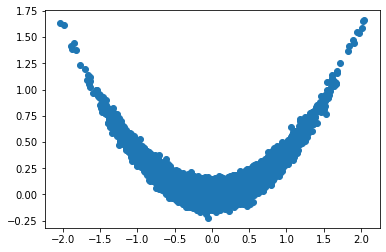

In [2]:
DATASET_SIZE = 20000
BATCH_SIZE = 500
SAMPLE_SIZE = DATASET_SIZE
OUTPUT_DIM = 2

params = (0.5,0.1,0.05,0.0) #(a1,a2,a3,theta)
bFlow = BananaFlow(params)
flip = tfb.Permute([1,0])
banana_yx = flip.forward(bFlow.sample(DATASET_SIZE))


banana_ds = tf.data.Dataset.from_tensor_slices(banana_yx)
banana_ds = banana_ds.prefetch(tf.data.experimental.AUTOTUNE)
banana_ds = banana_ds.cache()
banana_ds = banana_ds.shuffle(DATASET_SIZE).batch(BATCH_SIZE)

plt.scatter(banana_yx[:,1], banana_yx[:, 0])
plt.show()

In [3]:
from transport_nets.models import real_nvp_template
from transport_nets.models import MLP_ODE

class NF_TMAP(tf.keras.Model):
    def __init__(self,nvp_neurons,cnf_neurons,output_dim):
        super(NF_TMAP,self).__init__(name='nf_tmap')
        solver = tfp.math.ode.DormandPrince(atol=1e-5)
        ode_solve_fn = solver.solve
        # could also use trace_jacobian_hutchinson, which speeds up log density 
        # estimation significantly in higher dimensions O(D^2) -> O(D) 
        trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        num_shift_scale_fns = 1
        num_mlp_models = 2
        bijectors = []
        self.shift_scale_fns = num_shift_scale_fns*[None]
        for i in range(num_shift_scale_fns):
            self.shift_scale_fns[i] = real_nvp_template(neuron_list=nvp_neurons)
        self.mlp_models = num_mlp_models*[None]
        for i in range(num_mlp_models):
            self.mlp_models[i] = MLP_ODE(output_dim=1,neuron_list=cnf_neurons)
        self.bn_vars = []
        
        # 1-D continuous flow for upper block
        ffjord_bij_1 = tfb.FFJORD(
                            state_time_derivative_fn=self.mlp_models[0],
                            ode_solve_fn=ode_solve_fn,
                            trace_augmentation_fn=trace_augmentation_fn)
        # applies FFJORD bijector to upper block of triangular map and identity to lower block
        blockwise_ffjord_bij_1 = tfb.Blockwise(
                                    bijectors=[ffjord_bij_1, tfb.Identity()], 
                                    block_sizes=[1, 1])
        
        nvp_bij_1 = tfb.RealNVP(num_masked = 1, 
                            shift_and_log_scale_fn = self.shift_scale_fns[0])
        
        
        
        bn_bij_1 = tfb.BatchNormalization()
        bn_bij_1(tf.random.normal([1,1]))
        self.bn_vars.append(bn_bij_1.trainable_variables)
        
        blockwise_bn_1 = tfb.Blockwise(
                            bijectors=[tfb.Identity(),bn_bij_1])
        
        
        ffjord_bij_2 = tfb.FFJORD(
                            state_time_derivative_fn=self.mlp_models[1],
                            ode_solve_fn=ode_solve_fn,
                            trace_augmentation_fn=trace_augmentation_fn)
        
        blockwise_ffjord_bij_2 = tfb.Blockwise(
                                    bijectors=[tfb.Identity(),ffjord_bij_2], 
                                    block_sizes=[1, 1])
        

        bijectors += [blockwise_ffjord_bij_1,
                      nvp_bij_1,
                      blockwise_bn_1,
                      blockwise_ffjord_bij_2
                      ] 

        # reversing bijector list and chaining together 
        stacked_bijectors = tfb.Chain(bijectors[::-1])
        
        base_loc = tf.zeros([output_dim],dtype=tf.float32)
        base_sigma = tf.ones([output_dim],dtype=tf.float32)
        base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)
        
        self.flow = tfd.TransformedDistribution(
            distribution=base_distribution, bijector=stacked_bijectors)
        
    @tf.function   
    def call(self,inputs):
        return self.flow.bijector.forward(inputs)
    
    @tf.function   
    def inverse(self,inputs):
        return self.flow.bijector.inverse(inputs)
    
    @tf.function   
    def sample(self,N):
        return self.flow.sample(N) 
    
    def batch_norm_mode(self,training=True):
        for bij in self.flow.bijector.bijectors:
            if bij.name == 'batch_normalization':
                bij.training = False

In [4]:
@tf.function
def train_step(model,optimizer, target_sample):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(target_sample))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [5]:
LR = 1e-3
NUM_EPOCHS = 50
optimizer = tf.optimizers.Adam(learning_rate=LR,epsilon=1e-8)
nf_tmap = NF_TMAP([20,20],[50,50],2)
loss_history = []
t = trange(NUM_EPOCHS)
for epoch in t:
    for batch in banana_ds:
        loss = train_step(nf_tmap,optimizer, batch)
        loss_history.append(loss.numpy())
        t.set_description("loss: %0.3f"%loss.numpy())
        t.refresh()
nf_tmap.batch_norm_mode(False)

loss: -0.640: 100%|██████████| 50/50 [17:03<00:00, 20.46s/it]


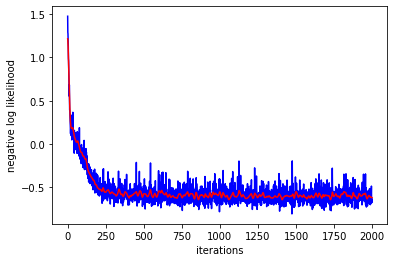

In [6]:
ysmoothed = gaussian_filter1d(loss_history, sigma=4)
plt.plot(loss_history,'b')
plt.plot(ysmoothed, color = 'r')
plt.xlabel('iterations')
plt.ylabel('negative log likelihood');

Text(0.5, 1.0, 'LT-NF map')

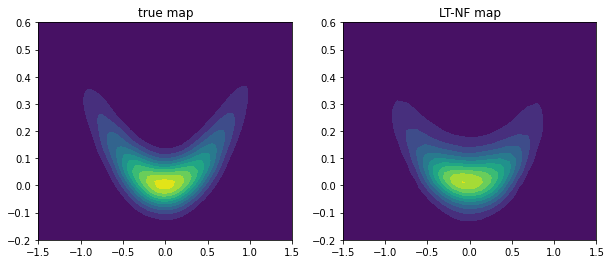

In [7]:
import seaborn as sns
def plot_density(data,axis):
    x, y = np.squeeze(np.split(data, 2, axis=1))
    return sns.kdeplot(x, y, cmap="viridis", shade=True, 
                     shade_lowest=True, ax=axis)
xa,xb,ya,yb = (-1.5,1.5,-0.2,0.6)
fig,ax = plt.subplots(1,2,figsize=(10,4))
T = bFlow.sample(10000)
X = nf_tmap.sample(10000)
X_flipped = flip.forward(X)
l1 = plot_density(T,axis=ax[0])
l2 = plot_density(X_flipped,axis=ax[1])
ax[0].set(xlim=(xa,xb),ylim=(ya,yb))
ax[1].set(xlim=(xa,xb),ylim=(ya,yb))

ax[0].set_title('true map')
ax[1].set_title('LT-NF map')
#plt.savefig('images/NTNF_kde.png')

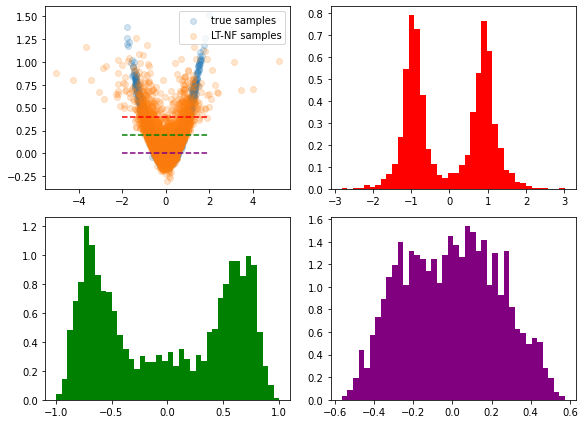

In [8]:
fig, ax = plt.subplots(2,2,figsize=(8,6))
x_obs_list = [0.4,0.2,0.0]
ax[0,0].scatter(T[:,0],T[:,1],alpha=0.2,label='true samples')
ax[0,0].scatter(X_flipped[:,0],X_flipped[:,1],alpha=0.2,label='LT-NF samples')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[0]*np.ones(100),'r--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[1]*np.ones(100),'g--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[2]*np.ones(100),'--',c='purple')
ax[0,0].legend()

x_obs_list = [0.5,0.2,0.0]
y0 = tf.zeros([1,1])
x_obs1 = tf.constant(x_obs_list[0],shape=[1,1])
x_obs2 = tf.constant(x_obs_list[1],shape=[1,1])
x_obs3 = tf.constant(x_obs_list[2],shape=[1,1])

r1 = nf_tmap.inverse(tf.concat([x_obs1,y0],axis=-1))[0,0]
r2 = nf_tmap.inverse(tf.concat([x_obs2,y0],axis=-1))[0,0]
r3 = nf_tmap.inverse(tf.concat([x_obs3,y0],axis=-1))[0,0]

Ns = 2000

X_cond1 = nf_tmap(tf.concat([r1*tf.ones([Ns,1]),tf.random.normal([Ns,1])],axis=-1))[:,1]
X_cond2 = nf_tmap(tf.concat([r2*tf.ones([Ns,1]),tf.random.normal([Ns,1])],axis=-1))[:,1]
X_cond3 = nf_tmap(tf.concat([r3*tf.ones([Ns,1]),tf.random.normal([Ns,1])],axis=-1))[:,1]

ax[0,1].hist(X_cond1,40,color='r',density=True)
ax[1,0].hist(X_cond2,40,color='g',density=True)
ax[1,1].hist(X_cond3,40,color='purple',density=True)
plt.tight_layout()
#plt.savefig('images/LTNF_conditional_samples.png')